<a href="https://colab.research.google.com/github/jshogland/SpatialModelingTutorials/blob/main/Notebooks/knn_sample_design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KNN: Sample Design
## In this notebook we will create a well spread and balanced sample to estimate cubic feet (CF) of timber for Custer Gallatin Forest using [Raster Tools](https://github.com/UM-RMRS/raster_tools) and remotely sensed imagery
### Objectives
- Learn about sample designs
- Learn how to access remotely sensed data (OSM, STAC & REST)
- Learn how to create a well spread and balanced sample that will be used to estimate volume

### Datasets
- Forest Boundary (OSM)
- Landsat Imagery (STAC, plantary computer)
- CF/acre [USFS Treemap REST](https://apps.fs.usda.gov/fsgisx01/rest/services/RDW_ForestEcology/TreeMap_2016_Volume_Live/ImageServer)

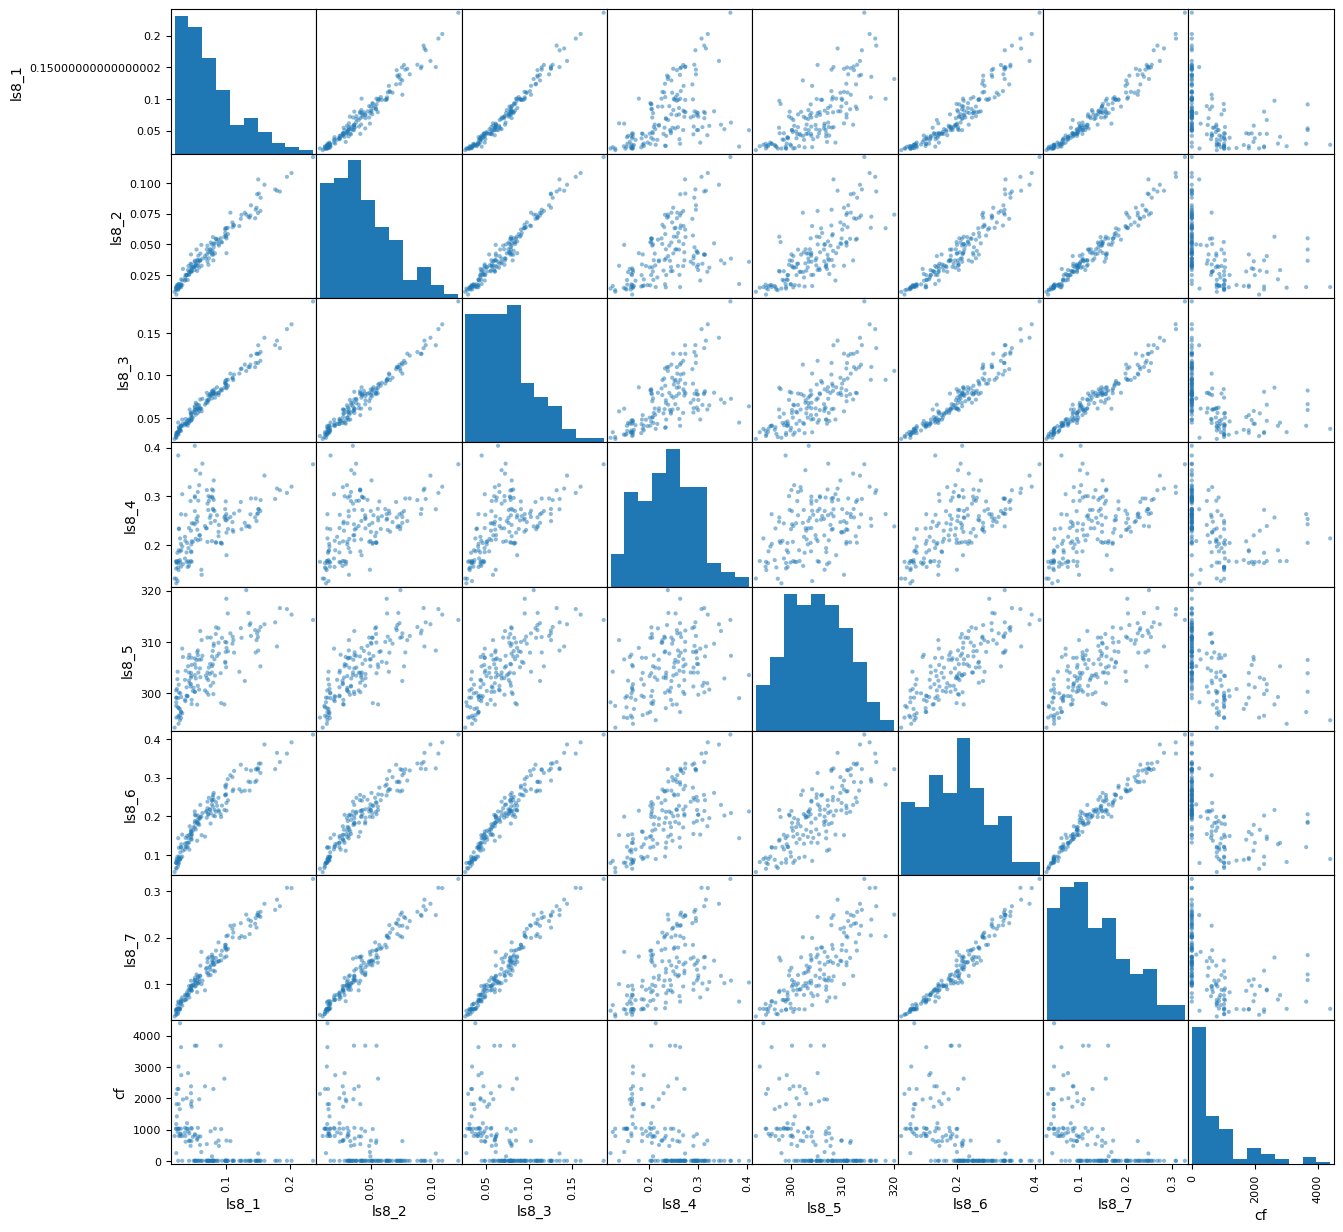

### Steps
1. Create a large random sample for a study area
2. Extract remotely sensed data for each location
3. Create a systematic random sample from the sorted list
4. Look at the distributions of the sample

by John Hogland 3/26/2024

## Install software

In [6]:
!pip install mapclassify
!pip install osmnx
!pip install raster_tools
!pip install install planetary-computer
!pip install pystac-client
!pip install stackstac

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.9/182.9 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 2.0 MB/s eta 0:00:00


## Import packages

In [7]:
#get packages
import osmnx as ox, planetary_computer, pystac_client, stackstac
import geopandas as gpd, pandas as pd, os, numpy as np, requests, urllib

from raster_tools import Raster,zonal
from shapely import geometry
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier


## Step 1: Create a large random sample
- Get the NF boundary
- Allocate 10,000 random locations

### Create Definitions

In [8]:
#Create a random sample definition
def get_random_sample(geom_p, n=1000):
    """
    produces a random sample given a geometry

    parameters:
    geom_p = (polygon) project polygon
    n = number of observations

    returns: geodataframe of point locations

    """
    xmin, ymin, xmax, ymax = geom_p.total_bounds
    xdif = xmax - xmin
    ydif = ymax - ymin
    pnts_lst = []
    while len(pnts_lst) < n:
        x = (np.random.random() * xdif) + xmin
        y = (np.random.random() * ydif) + ymin
        pnt = geometry.Point([x, y])
        if pnt.intersects(geom_p).values:
            pnts_lst.append(pnt)

    dic = {"geometry": pnts_lst}
    gdf = gpd.GeoDataFrame(dic, crs=geom_p.crs)

    return gdf



### Create Sample

In [9]:
#use OpenStreetMaps to get the boundary of the NF
nf=ox.geocode_to_gdf('Custer Gallatin National Forest, MT, USA')

#get first polygon of the NF
nfe=nf.explode()
nf1=gpd.GeoSeries(nfe.geometry.iloc[10],crs=nf.crs)

#project to Albers equal area
nf1p=nf1.to_crs(5070)

#us smpDs.py random sample function to create 10,000 locations within the nf1
pnts=get_random_sample(nf1p,10000)

#Visualize the nf1 and sample locations
m=nf1p.explore()
m=pnts.explore(m=m,color='yellow')
m

<ipython-input-9-bac38e81a9d8>:5: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  nfe=nf.explode()


## Step 2: Extract remotely sensed data for each location
### Create definitions

In [10]:
#create definition to mosaic stac data
def mosaic_stac(xr):
    return stackstac.mosaic(xr)

#create definition to extract stac data
def get_stac_data(geo,url="https://planetarycomputer.microsoft.com/api/stac/v1",name="sentinel-2-l2a",res=30,crs=5070,**kwarg):
    '''
    gets tiled data from planetary computer as a dask backed xarray that intersects the geometry of the point, line, or polygon

    geo = (polygon) geometry bounding box (WGS84)
    url = (string) base url to planetary computer https://planetarycomputer.microsoft.com/api/stac/v1
    name = (string) catelog resource
    qry =  (dictoinary) of property values {'eo:cloud_cover':{'lt':1}}
    res = (tuple of numbers) output resolution (x,y)
    crs = (int) output crs
    dt = (string) data time intervale e.g., one month: 2023-06, range: 2023-06-02/2023-06-17
    limit = (int) max number of items to return

    returns (xarray data array and stac item catalog)
    '''
    catalog = pystac_client.Client.open(url, modifier=planetary_computer.sign_inplace)
    srch = catalog.search(collections=name, intersects=geo, **kwarg)
    ic = srch.item_collection()
    if(len(ic.items)>0):
        xra = stackstac.stack(ic,resolution=res,epsg=crs)
        xra = mosaic_stac(xra)
    else:
        xra=None

    return xra,ic

#Create definition to extract image service data
def get_image_service_data(url, ply, out_prefix,res=30,outSR=""):
    '''
    extracts a list of images from a image service given a url, polygon, and output prefix name

    url = (string) path to image service e.g., url=r'https://lfps.usgs.gov/arcgis/rest/services/Landfire_LF230/US_230EVT/ImageServer'
    ply = (geoseries or geodataframe) of the study area
    out_prefix = (string) prefix used to save each image
    '''
    layerInfo=requests.get(url+'?f=pjson')
    dic=layerInfo.json()
    #print(dic)
    spr=dic['spatialReference']
    m_width=dic['maxImageWidth']
    m_height=dic['maxImageHeight']
    fitem=next(iter(spr))
    ply2=ply.to_crs(spr[fitem])

    xmin,ymin,xmax,ymax=ply2.total_bounds

    wcells=int((xmax-xmin)/res)
    hcells=int((ymax-ymin)/res)

    if(wcells<m_width):
        m_width=wcells

    if(hcells<m_height):
        m_height=hcells


    wcells_l=np.arange(0,wcells,m_width)
    hcells_l=np.arange(0,hcells,m_height)

    xmax2=xmin
    ymax2=ymin

    tile=1

    rs_lst=[]
    for w in wcells_l:
        for h in hcells_l:
            xmax2 = (m_width*res+xmax2)
            ymax2 = (m_height*res+ymax2)

            qry = url+'/exportImage?'
            parm = {
                'f':'json',
                'bbox':','.join([str(xmin),str(ymin),str(xmax2),str(ymax2)]),
                'size':str(m_width) + ',' + str(m_height),
                'imageSR':outSR,
                'format':'tiff'
            }
            print(parm['bbox'])
            response=requests.get(qry,parm)
            if response.status_code == 200:
                img_url=response.json()['href']
                outname=out_prefix + str(tile) + '.tif'
                urllib.request.urlretrieve(img_url, outname)
                rs_lst.append(Raster(outname))
                tile+=1

    return rs_lst


### Extract data

/usr/local/lib/python3.10/dist-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


-12093481.78980173,5635521.302800711,-12057721.78980173,5656191.302800711


geometry     ls8_1     ls8_2     ls8_3     ls8_4  \
0     POINT (-981390.760 2520777.040)  0.064578  0.042027  0.071232  0.288538   
1     POINT (-987044.116 2525721.254)  0.170865  0.093288  0.141055  0.291728   
2     POINT (-979077.398 2527189.512)  0.062377  0.033805  0.068510  0.319777   
3     POINT (-975578.881 2533699.769)  0.050772  0.030532  0.061443  0.291535   
4     POINT (-981910.400 2520454.666)  0.069940  0.046593  0.074477  0.258837   
...                               ...       ...       ...       ...       ...   
9995  POINT (-971709.456 2521535.811)  0.073130  0.050745  0.072113  0.234225   
9996  POINT (-971459.284 2532771.411)  0.052532  0.036830  0.065815  0.277317   
9997  POINT (-980468.101 2527338.525)  0.070270  0.037628  0.068647  0.253475   
9998  POINT (-966637.067 2529830.478)  0.076128  0.054540  0.072057  0.204003   
9999  POINT (-979314.485 2528896.560)  0.087898  0.046262  0.082480  0.295770   

           ls8_5     ls8_6     ls8_7         cf_1           cf  
0     308.611280  0.217450  0.132145   -99.000000     0.000000  
1     313.075214  0.339055  0.266153   -99.000000     0.000000  
2     302.479352  0.207852  0.119880   -99.000000     0.000000  
3     303.877322  0.183762  0.105608   -99.000000     0.000000  
4     313.095722  0.210740  0.135225   -99.000000     0.000000  
...          ...       ...       ...          ...          ...  
9995  313.857941  0.217037  0.150873   -99.000000     0.000000  
9996  306.259682  0.186100  0.103187   906.450034   906.450034  
9997  303.224480  0.231942  0.140917   -99.000000     0.000000  
9998  309.424769  0.245445  0.190335  2295.805002  2295.805002  
9999  302.988637  0.245802  0.163413   -99.000000     0.000000  

[10000 rows x 10 columns]

array([[<Axes: xlabel='ls8_1', ylabel='ls8_1'>,
        <Axes: xlabel='ls8_2', ylabel='ls8_1'>,
        <Axes: xlabel='ls8_3', ylabel='ls8_1'>,
        <Axes: xlabel='ls8_4', ylabel='ls8_1'>,
        <Axes: xlabel='ls8_5', ylabel='ls8_1'>,
        <Axes: xlabel='ls8_6', ylabel='ls8_1'>,
        <Axes: xlabel='ls8_7', ylabel='ls8_1'>,
        <Axes: xlabel='cf_1', ylabel='ls8_1'>,
        <Axes: xlabel='cf', ylabel='ls8_1'>],
       [<Axes: xlabel='ls8_1', ylabel='ls8_2'>,
        <Axes: xlabel='ls8_2', ylabel='ls8_2'>,
        <Axes: xlabel='ls8_3', ylabel='ls8_2'>,
        <Axes: xlabel='ls8_4', ylabel='ls8_2'>,
        <Axes: xlabel='ls8_5', ylabel='ls8_2'>,
        <Axes: xlabel='ls8_6', ylabel='ls8_2'>,
        <Axes: xlabel='ls8_7', ylabel='ls8_2'>,
        <Axes: xlabel='cf_1', ylabel='ls8_2'>,
        <Axes: xlabel='cf', ylabel='ls8_2'>],
       [<Axes: xlabel='ls8_1', ylabel='ls8_3'>,
        <Axes: xlabel='ls8_2', ylabel='ls8_3'>,
        <Axes: xlabel='ls8_3', ylabel='ls8_3'>

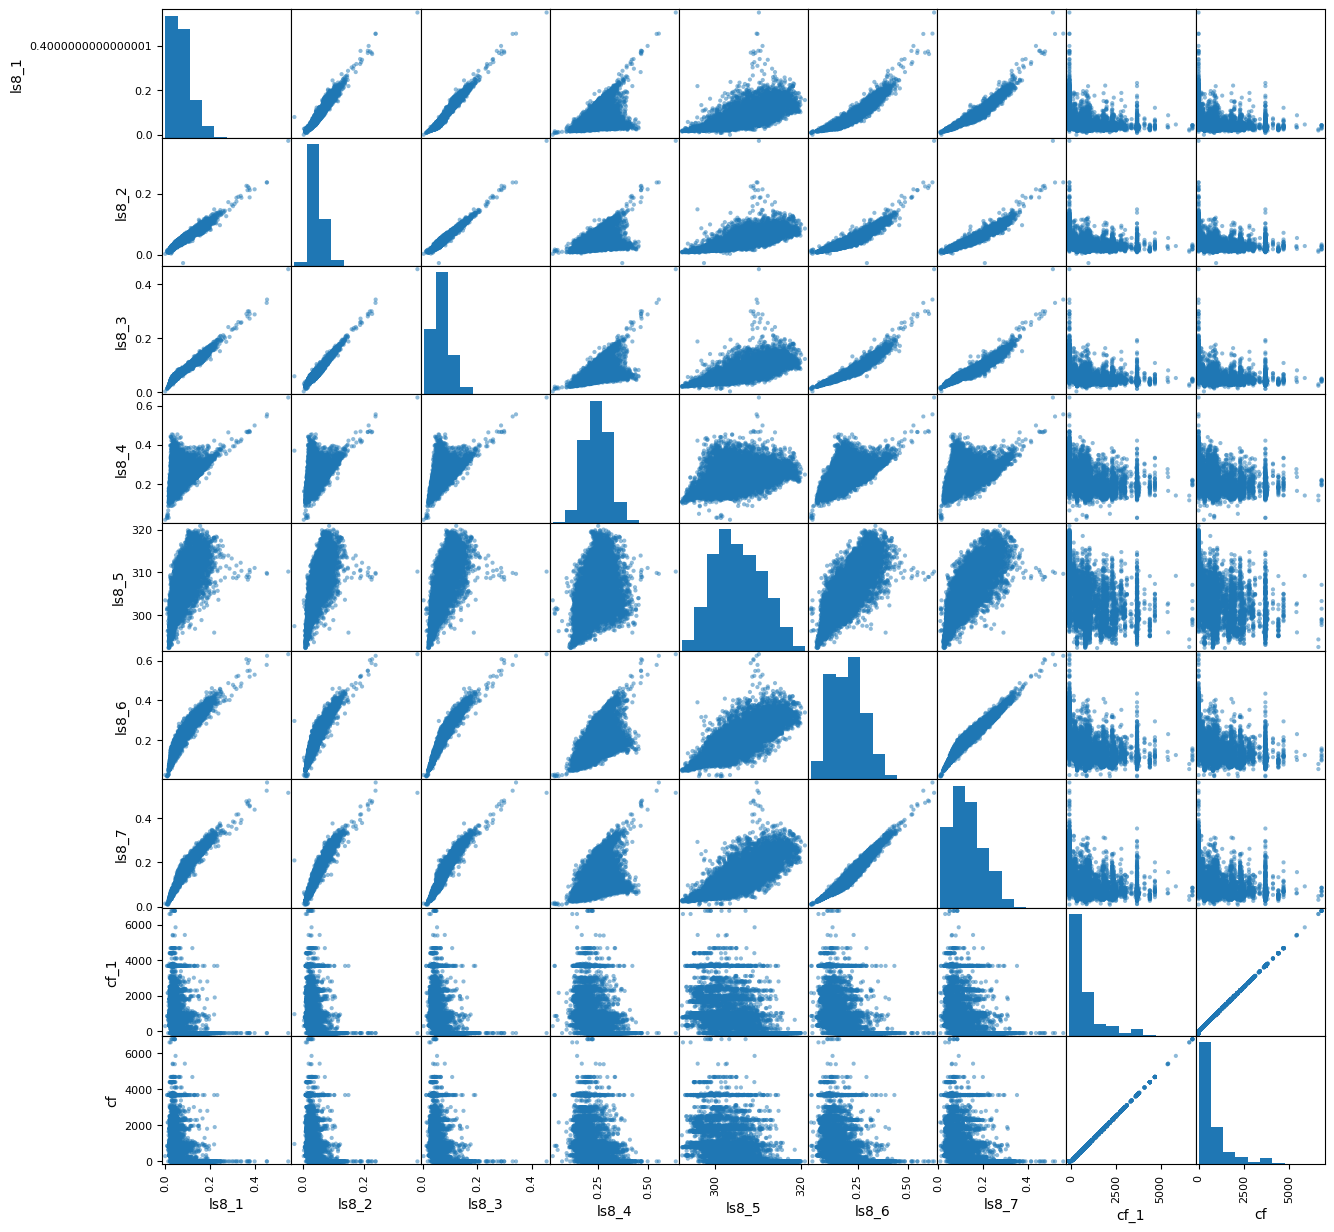

In [11]:
#get stac data
if(not os.path.exists('ls8.tif')):
    xmin,ymin,xmax,ymax=nf1p.buffer(200).total_bounds
    ls30, ic =get_stac_data(nf1.geometry[0],"https://planetarycomputer.microsoft.com/api/stac/v1",name="landsat-c2-l2",res=30,crs=5070,datetime='2023-07-15/2023-07-30',query={'eo:cloud_cover':{'lt':10},'platform':{'eq':'landsat-8'}},limit=1000)
    ls30s=Raster(ls30.sel(band=['red', 'blue', 'green', 'nir08', 'lwir11','swir16', 'swir22'],x=slice(xmin,xmax),y=slice(ymax,ymin)))
    ls30s=ls30s.save('ls8.tif')

#get REST data
if(not os.path.exists('cf1.tif')):
    im_lst=get_image_service_data(url=r'https://apps.fs.usda.gov/fsgisx01/rest/services/RDW_ForestEcology/TreeMap_2016_Volume_Live/ImageServer',ply=nf1,out_prefix='cf',res=30,outSR=5070)
    ccf_rs=im_lst[0]

#Extract point data
ccf_rs=Raster('cf1.tif')
ls30s=Raster('ls8.tif')

ls_tbl=zonal.extract_points_eager(pnts,ls30s,'ls8',axis=1).compute()
pred=ls_tbl.columns

ccf_tbl=zonal.extract_points_eager(pnts,ccf_rs,'cf',axis=1).compute()

#set null values -99 to 0
vls=ccf_tbl['cf_1']
ccf_tbl['cf']=vls.where(vls>0,0)


#Join values to pnts geodataframe
bsmp=pnts.join(ls_tbl.join(ccf_tbl))

#visualize the data
display(bsmp)
pd.plotting.scatter_matrix(bsmp,figsize=(15,15))

## Step 3 Create systematic random sample using a sorted list and Euclidean distance (n=150)
### Create definitions

In [12]:
def _create_knn(df,pred,neighbors=1):
    '''
    Creates a knn given a dataframe and a list of predictors
    df = dataframe
    pred = list of predictors
    neighbors = (int) number of neighbors to return

    return a knn model
    '''
    X = df[pred]
    y = df['plotid']
    neigh = KNeighborsClassifier(n_neighbors=neighbors)
    neigh.fit(X,y)
    return neigh

def _impute_plots(rsmp,nn_rws,clm_nms):
    '''
    imputes plot ids from accessible areas to inaccessible areas
    rsmp = random sample dataframe
    nn_rws = candidate plot dataframe. Locations in accessible areas that were not part of the original random sample
    clm_nms = list of column names used as predictor variables

    returns a new dataframe of imputed plots. Plot ids that were duplicated are set to NA
    '''
    acc_ch = rsmp['Accessible']==True
    acc_sel=rsmp[acc_ch]
    if(acc_sel.shape[0]>0):
        acc_sel['imp_plotid']=acc_sel['plotid']
        acc_sel['nn_dist']=0

    #get points outside accessible area that where chosen
    acc_ch2=rsmp['Accessible']==False
    acc_smp_nsel=rsmp[acc_ch2]
    #imput plot ids
    nn = _create_knn(nn_rws,clm_nms)
    nw_lbl=nn.predict(acc_smp_nsel[clm_nms])
    nw_dist=nn.kneighbors(acc_smp_nsel[clm_nms])
    #remove duplicated plot ids
    vls,ind=np.unique(nw_lbl,return_index=True)
    nw_lbl2=np.full_like(nw_lbl,np.nan)
    nw_lbl2[ind]=vls
    #add imputed field and plot ids
    acc_smp_nsel['imp_plotid']=nw_lbl2
    acc_smp_nsel['nn_dist']=nw_dist[0]
    if(acc_ch.shape[0]>0):
        return pd.concat([acc_sel,acc_smp_nsel])
    else:
        return acc_smp_nsel

def impute_accessible_plots(bsmp,clm_nms,subarea=None,n=250,sys=False):
    '''
    bsmp (dataframe) =  population dataframe
    subarea (polygon geodataframe) = geodataframe of accessible areas
    clm_nms (list of strings) = list of column names used as predictor variables
    n (int) = sample size
    sys (bool) = used to determine if we are using a systematic random sample from a sorted list of distances or a simple random sample

    returns a geodataframe of selected observations
    '''

    if(not ('plotid' in list(bsmp.columns))): bsmp['plotid']=bsmp.index

    #Normalize and center variable values
    X=bsmp[clm_nms]
    ss=StandardScaler()
    ss.fit(X)
    X2=ss.transform(X)

    #Perform PCA, transform scaled values, and perform K-means classification
    pca=PCA()
    pca.fit(X2)
    X3=pca.transform(X2)
    clm_nms2=[]
    for c in range(X3.shape[1]):
        clm_nms2.append('comp_' + str(c+1))

    bsmp=bsmp.join(pd.DataFrame(X3,columns=clm_nms2))

    if(sys):
        #calc distance, sort, and create random start to get ids
        X = bsmp[clm_nms2]
        dist=((X-X.min(axis=0)).pow(2)).sum(axis=1)
        id_sort=dist.sort_values()
        N=X.shape[0]
        skp=N/n
        st=np.random.randint(0,int(skp))
        idlst=np.arange(st,N,skp).astype('int32')
        ids2=id_sort.iloc[idlst].index

    else:
        #create a random sample from all locations
        ids2=np.random.choice(bsmp.index,n,replace=False)

    #subset the random sample (rsmp)
    rsmp=bsmp[bsmp.index.isin(ids2)]

    #get accessible area
    if(subarea is None):
        pass
    else:
        subarea_p=subarea.to_crs(bsmp.crs)
        acc_ch = bsmp.intersects(subarea_p.unary_union)

        bsmp['Accessible']= acc_ch
        acc=bsmp[acc_ch]

        #subset all locations within the accessible areas that were not chosen in the random sample these will be used to impute nn
        nn_rws=acc[~acc.index.isin(ids2)]



        #impute plotids to nn using nn_rws
        rsmp =_impute_plots(rsmp,nn_rws,clm_nms)

        #check to see how many plots were duplicated
        chk = (rsmp['imp_plotid'].isna()).sum()

        #perform a loop to fill in duplicated plot ids
        while chk > 0:
            #find the duplicated records (NA)
            impchk=rsmp['imp_plotid'].isna()
            #split the data into two groups imputed records and duplicated
            irsmp=rsmp[~impchk]
            nrsmp=rsmp[impchk]
            #remove all plots that previously were imputed
            vls = irsmp['imp_plotid']
            nn_rws=nn_rws[~nn_rws['plotid'].isin(vls)]
            #impute plots
            trsmp=_impute_plots(nrsmp,nn_rws,clm_nms)
            #compbine results and recheck for NAs
            rsmp=pd.concat([irsmp,trsmp])
            chk = (rsmp['imp_plotid'].isna()).sum()

    return rsmp

### Create sample

In [13]:
smp_t = impute_accessible_plots(bsmp=bsmp,clm_nms=pred,subarea=None,n=150,sys=True)
smp_t[list(pred)+['cf','geometry']].to_file('sb_sample.shp.zip')

### Visualize the sample

In [14]:
smp = gpd.read_file('sb_sample.shp.zip')
display(smp)
smp.explore()

ls8_1     ls8_2     ls8_3     ls8_4       ls8_5     ls8_6     ls8_7  \
0    0.057098  0.044338  0.058555  0.216075  307.924258  0.215388  0.158270   
1    0.045218  0.040625  0.062680  0.358882  303.709839  0.202930  0.102693   
2    0.074725  0.049068  0.071755  0.206340  312.278815  0.223472  0.145317   
3    0.165392  0.093095  0.136490  0.296760  316.134342  0.310922  0.244785   
4    0.049728  0.030505  0.053468  0.212693  304.769425  0.149910  0.087485   
..        ...       ...       ...       ...         ...       ...       ...   
145  0.025308  0.017442  0.041780  0.252953  299.714174  0.115260  0.055805   
146  0.150570  0.072938  0.111190  0.251798  316.048891  0.292772  0.237910   
147  0.071892  0.049342  0.065458  0.167043  303.617553  0.186128  0.137013   
148  0.084460  0.048682  0.081903  0.245473  306.765549  0.215113  0.159260   
149  0.060178  0.037518  0.059435  0.205873  304.431041  0.168060  0.114297   

              cf                         geometry  
0    1052.965406  POINT (-971511.034 2530009.792)  
1    3679.127421  POINT (-966435.178 2529601.285)  
2       0.000000  POINT (-984278.914 2533645.259)  
3       0.000000  POINT (-986987.822 2523490.789)  
4       0.000000  POINT (-986888.365 2533294.962)  
..           ...                              ...  
145  2381.203290  POINT (-975080.854 2526034.562)  
146     0.000000  POINT (-984308.631 2521537.277)  
147   141.578655  POINT (-979827.158 2522485.453)  
148     0.000000  POINT (-972209.777 2522926.565)  
149     0.000000  POINT (-979402.176 2524527.307)  

[150 rows x 9 columns]

## Step 4: Look at the distribution of the spread and balanced sample

<Axes: >

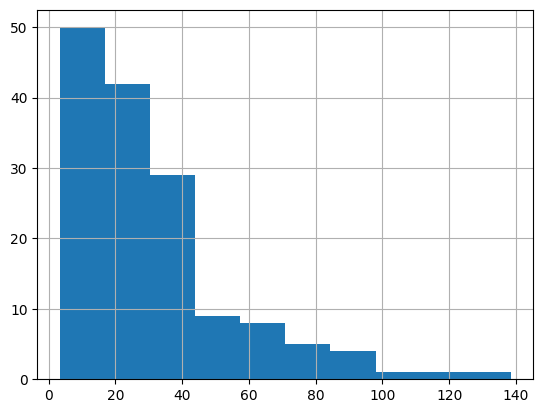

In [15]:
cnms=[]
for i in range(1,8):
    cnms.append('comp_'+str(i))

X=smp_t[cnms]
dist=((X-X.min(axis=0)).pow(2)).sum(axis=1)
dist.hist()

In [16]:
display(smp[pred].describe())
display(bsmp[pred].describe())

ls8_1       ls8_2       ls8_3       ls8_4       ls8_5       ls8_6  \
count  150.000000  150.000000  150.000000  150.000000  150.000000  150.000000   
mean     0.072401    0.043859    0.070542    0.240633  305.242776    0.200727   
std      0.043004    0.023215    0.030584    0.060653    5.351520    0.080858   
min      0.015765    0.008725    0.021705    0.112537  292.320997    0.046427   
25%      0.036438    0.025974    0.044991    0.198461  301.245447    0.130261   
50%      0.062776    0.040432    0.066736    0.244125  304.805315    0.208842   
75%      0.089218    0.055262    0.085230    0.281807  308.761673    0.250416   
max      0.206340    0.121722    0.172157    0.407200  317.354575    0.435415   

            ls8_7  
count  150.000000  
mean     0.133453  
std      0.069086  
min      0.023822  
25%      0.073508  
50%      0.129395  
75%      0.170783  
max      0.331740

ls8_1         ls8_2         ls8_3         ls8_4         ls8_5  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.072259      0.043892      0.070944      0.242930    305.358668   
std        0.045435      0.024774      0.032227      0.060467      5.588463   
min       -0.000350     -0.027630      0.003060      0.019890    292.249218   
25%        0.036603      0.024730      0.045960      0.197980    301.015585   
50%        0.061649      0.039002      0.066310      0.243658    304.892474   
75%        0.093095      0.057352      0.086694      0.284392    309.576016   
max        0.549127      0.374723      0.455077      0.640895    320.946914   

              ls8_6         ls8_7  
count  10000.000000  10000.000000  
mean       0.199972      0.132433  
std        0.080984      0.070202  
min        0.017525      0.009412  
25%        0.133053      0.073515  
50%        0.200070      0.121915  
75%        0.253475      0.176372  
max        0.632232      0.560018

array([[<Axes: xlabel='ls8_1', ylabel='ls8_1'>,
        <Axes: xlabel='ls8_2', ylabel='ls8_1'>,
        <Axes: xlabel='ls8_3', ylabel='ls8_1'>,
        <Axes: xlabel='ls8_4', ylabel='ls8_1'>,
        <Axes: xlabel='ls8_5', ylabel='ls8_1'>,
        <Axes: xlabel='ls8_6', ylabel='ls8_1'>,
        <Axes: xlabel='ls8_7', ylabel='ls8_1'>,
        <Axes: xlabel='cf', ylabel='ls8_1'>],
       [<Axes: xlabel='ls8_1', ylabel='ls8_2'>,
        <Axes: xlabel='ls8_2', ylabel='ls8_2'>,
        <Axes: xlabel='ls8_3', ylabel='ls8_2'>,
        <Axes: xlabel='ls8_4', ylabel='ls8_2'>,
        <Axes: xlabel='ls8_5', ylabel='ls8_2'>,
        <Axes: xlabel='ls8_6', ylabel='ls8_2'>,
        <Axes: xlabel='ls8_7', ylabel='ls8_2'>,
        <Axes: xlabel='cf', ylabel='ls8_2'>],
       [<Axes: xlabel='ls8_1', ylabel='ls8_3'>,
        <Axes: xlabel='ls8_2', ylabel='ls8_3'>,
        <Axes: xlabel='ls8_3', ylabel='ls8_3'>,
        <Axes: xlabel='ls8_4', ylabel='ls8_3'>,
        <Axes: xlabel='ls8_5', ylabel='ls8_3

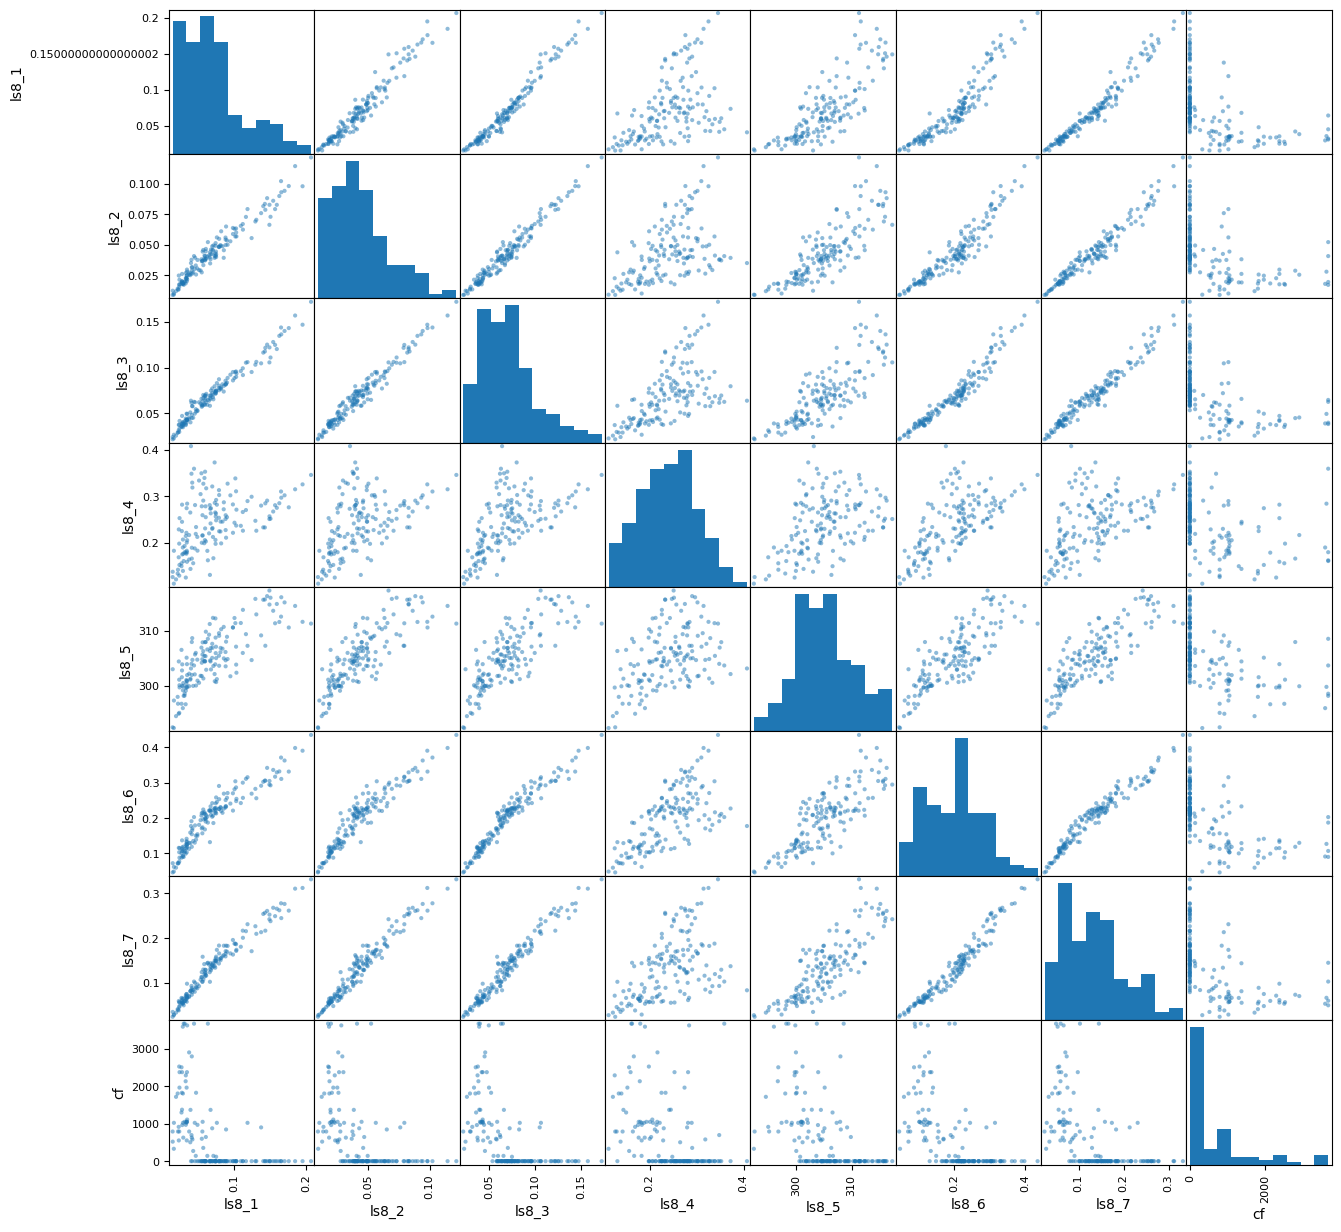

In [17]:
pd.plotting.scatter_matrix(smp[list(pred)+['cf']],figsize=(15,15))